# Path-encoded 4-qubit GHZ states probabilistic generator

@Author: Mathias Pont (mathias.pont@c2n.upsaclay.fr)<br>
@Affiliation:<br>
Centre for Nanosciences and Nanotechnology, CNRS, Universite Paris-Saclay, UMR 9001,<br>
10 Boulevard Thomas Gobert,<br>
91120 Palaiseau, France<br>

In [1]:
import itertools
import numpy as np
import time
from multiprocessing import Pool, cpu_count
from contextlib import contextmanager
import numpy as np
import itertools
from datetime import datetime
import os 
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
# The notebook can be easily adapted to run without this import
from utils import gate_fidelity, set_filename

In [3]:
from qiskit.visualization import plot_state_city
import QuantumTomography as qLib
from get_tomography import get_tomography

In [4]:
import perceval as pcvl
import perceval.lib.symb as symb

In [5]:
measurements_density_matrix = list(itertools.product(['sigmax', 'sigmay', 'sigmaz'], repeat=4))

# Target 4-GHZ state density matrix rho_GHZ
state = (2 ** 4) * [0]
state[5] = 1
state[10] = np.tan(np.pi/4)
state = state/np.sqrt(2)
rho_GHZ = np.kron(state, state).reshape(len(state), len(state))

In [6]:
def preselect_input(p, nb_of_photons, lower_bound=1e-8):
    input_StdV = []
    for i in p.source_distribution.keys():
        input_StdV.append(i)

    for input_state in input_StdV:
        if input_state.n[0] < nb_of_photons:
            del p.source_distribution[input_state]

    input_StdV = []
    for i in p.source_distribution.keys():
        input_StdV.append(i)

    n_photon_dominant_term = max(p.source_distribution.values())
    for input_state in input_StdV:
        if p.source_distribution[input_state] < lower_bound*n_photon_dominant_term:
            del p.source_distribution[input_state]

def postselect_output(output_state):
    state_list = []
    for m in str(output_state):
        if m.isdigit():
            state_list.append(m)

    state = ''.join(state_list)

    nb_of_result = 4 - state.count('0') + 1
    s = nb_of_result * ['']
    N = []
    c = 1
    for i in range(nb_of_result):
        for party in range(4):
            if int(state[2 * party]) == 0 and int(state[2 * party + 1]) > 0:
                s[i] += '1'
                N.append(int(state[2 * party + 1]))
            if int(state[2 * party]) > 0 and int(state[2 * party + 1]) == 0:
                s[i] += '0'
                N.append(int(state[2 * party]))
            if int(state[2 * party]) > 0 and int(state[2 * party + 1]) > 0:
                if c % 2 == 0:
                    s[i] += '1'
                else:
                    s[i] += '0'
                N.append(int(state[2 * party]) + int(state[2 * party + 1]))
        c += 1

    if len(s) == 0 or len(s[0]) < 4:
        return None, N
    else:
        return s, N

In [7]:
class QPU:

    def __init__(self):

        self.outcome = ["".join(i) for i in list(itertools.product(['0', '1'], repeat=4))]

        self.circuit = pcvl.Circuit(m=8, name="GHZ")

        self.phase_shifters = []

        self.coupler_R = [0.5, 0.505, 0.4905, 0.503] # Measured coupler reflectivities
        #self.coupler_R = 4*[0.5] # Ideal directional couplers

        for i in range(1, 9):
            self.phase_shifters.append(pcvl.Parameter(f'phi{i}'))
        for i in range(4):
            self.circuit.add((2 * i, 2 * i + 1), symb.BS(R=self.coupler_R[i]))
        for i in range(3):
            self.circuit.add((2 * i + 1, 2 * i + 2), symb.PERM([1, 0]))
        for i in range(4):
            self.circuit.add(2 * i, symb.PS(self.phase_shifters[i]))
        for i in range(4):
            self.circuit.add((2 * i, 2 * i + 1), symb.BS())
        for i in range(4):
            self.circuit.add(2 * i, symb.PS(self.phase_shifters[i + 4]))
        for i in range(4):
            self.circuit.add((2 * i, 2 * i + 1), symb.BS())

        self.measurement = dict()

        self.measurement['sigmax'] = [0, np.pi / 2]
        self.measurement['sigmay'] = [np.pi/2, np.pi / 2]
        self.measurement['sigmaz'] = [0, np.pi]
        self.measurement['Id'] = [0, np.pi]

        self.simulator_backend = pcvl.BackendFactory().get_backend('Naive')

In [8]:
qpu = QPU()
# Display the interferometer.
pcvl.pdisplay(qpu.circuit, format='mplot')

In [9]:
def compute(qpu, context, g2, M_A, M_B, M_C, M_D, beta=1, eta=1):

    empirical_table = {context: {}}

    # Imperfect single photon source 
    source1 = pcvl.Source(brightness=beta,
                         multiphoton_component=g2,
                         indistinguishability=M_A,
                         multiphoton_model="distinguishable",
                         indistinguishability_model="homv",
                         overall_transmission=eta)
    source2 = pcvl.Source(brightness=beta,
                         multiphoton_component=g2,
                         indistinguishability=M_B,
                         multiphoton_model="distinguishable",
                         indistinguishability_model="homv",
                         context=source1._context,
                         overall_transmission=eta)
    source3 = pcvl.Source(brightness=beta,
                         multiphoton_component=g2,
                         indistinguishability=M_C,
                         multiphoton_model="distinguishable",
                         indistinguishability_model="homv",
                         context=source2._context,
                         overall_transmission=eta)    
    source4 = pcvl.Source(brightness=beta,
                         multiphoton_component=g2,
                         indistinguishability=M_D,
                         multiphoton_model="distinguishable",
                         indistinguishability_model="homv",
                         context=source3._context,
                         overall_transmission=eta)

    # set up the phases
    context_PS = []
    for party in context:
        context_PS.append(qpu.measurement[party])
    # Psi is the first two (phase theta of the GHZ state)
    # Phi is the phases of the MZIs
    c_Psi = 0
    c_Phi = 4
    for phase_party in context_PS:
        qpu.phase_shifters[c_Psi].set_value(phase_party[0])
        qpu.phase_shifters[c_Phi].set_value(phase_party[1])
        c_Psi += 1
        c_Phi += 1

    p = pcvl.Processor({0: source1,
                        2: source2,
                        4: source3,
                        6: source4},
                       qpu.circuit)
    
    preselect_input(p, 4)
    
    input_states_dict = {str(k): v for k, v in p.source_distribution.items()}

    all_p, sv_out = p.run(qpu.simulator_backend)

    for output_state in sv_out:
        all_possible_result, N = postselect_output(output_state)
        if all_possible_result is not None:
            nb_of_results = len(all_possible_result)
            for result in all_possible_result:
                # Initialize the empirical table if this result doesn't exist yet.
                if result not in empirical_table[context]:
                    empirical_table[context][result] = sv_out[output_state] / nb_of_results
                # Add the probabilility to the result if it has already been created.
                else:
                    empirical_table[context][result] += sv_out[output_state] / nb_of_results

    for outcome in qpu.outcome:
        if outcome not in empirical_table[context]:
            empirical_table[context][outcome] = 0.0

    norm_factor = np.sum([empirical_table[context][x] for x in qpu.outcome])
    dict_normed = {}
    for outcome in qpu.outcome:
        val = empirical_table[context][outcome]
        # if the probability is near 0, replace it by 0
        if val < 1e-30:
            dict_normed[outcome] = 0
        else:
            dict_normed[outcome] = empirical_table[context][outcome] / norm_factor
    empirical_table[context] = dict_normed

    return empirical_table

In [15]:
# Run the experiment with multi-processing
@contextmanager
def terminating(thing):
    try:
        yield thing
    finally:
        thing.terminate()


def run(list_of_measurements, g2=0, M_A=1, M_B=1, M_C=1, M_D=1,
        beta=1, eta=1, output_type={}):

    with terminating(Pool(processes=min(cpu_count() - 2, len(list_of_measurements)))) as p:
        results = [p.apply_async(compute,
                                 args=(QPU(),
                                       context,
                                       g2,
                                       M_A, M_B, M_C, M_D,
                                       beta,
                                       eta)) for context in list_of_measurements]

        output = np.asarray([r.get() for r in results], dtype=None)

    e_t = {}
    for d in output: e_t.update(d)

    if type(output_type) == dict:
        return e_t
    if type(output_type) == list:
        list_of_histograms = []
        for context in list_of_measurements:
            probs = []
            for outcome in e_t[context]:
                probs.append(e_t[context][outcome])
            list_of_histograms.append(probs)

        return np.array(list_of_histograms)

In [16]:
g2=0.005

# Computed sqrt(x_i) from M_ij
V_A=0.94
V_B=0.88
V_C=0.90
V_D=0.90

beta=1
eta=0.1*0.5

counts = run(measurements_density_matrix, 
             g2=g2, M_A=V_A, M_B=V_B, M_C=V_C, M_D=V_D,
             beta=beta,
             eta=eta,
             output_type=[])

rho, _, _ = get_tomography(counts)

Fidelity = 0.9996921397667848
Purity = 0.9999965423445548


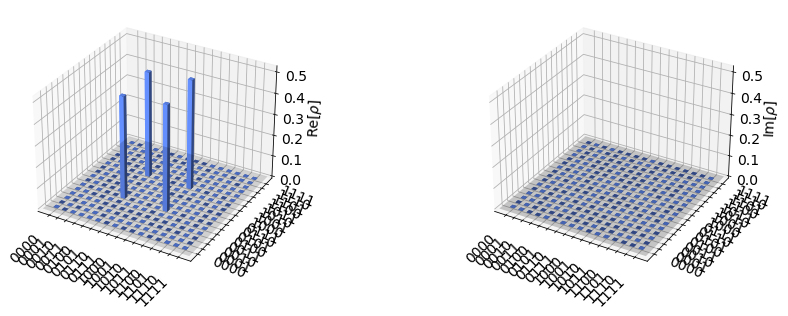

In [17]:
plot_state_city(rho)